
# Module 13 -- Time Series -- Predict Demand

## The Data

Data is about passenger traffic of company SeaAirport. SearAirport operated Sea Planes across USA. Fields are: <br>
Month: Month in which traffic data was recorded <br>
'#Passenger': No of travellers availing Service in that month
____


## Getting Started

Let's import some libraries we will need:

In [2]:
# Import Packages
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

#importing packages for the prediction of time-series data
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.metrics import mean_squared_error

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

Read the data using pandas in DataFrame df

In [3]:
cd D:\Darvin\python training

D:\Darvin\python training


In [4]:
df = pd.read_csv('share.csv')

Let's take a quick look at the data.

In [5]:
df.head(10)

,Date,Close
0,4/23/2019,11575.95020
1,4/24/2019,11726.15039
2,4/25/2019,11641.79981
3,4/26/2019,11754.65039
4,4/30/2019,11748.15039
5,5/2/2019,11724.75000
6,5/3/2019,11712.25000
7,5/6/2019,11598.25000
8,5/7/2019,11497.90039
9,5/8/2019,11359.45020


**More Inspections**

In [6]:
print (df.index)
print (df.describe())
print ("=============================================================")
print (df.dtypes)

RangeIndex(start=0, stop=244, step=1)
              Close
count    244.000000
mean   11339.880137
std     1012.609323
min     7610.250000
25%    11100.362305
50%    11675.325195
75%    11969.250245
max    12362.299810
Date      object
Close    float64
dtype: object


Lets do a basic plot of data to visualize <br>
** Q1. What inference can you draw from the plot?  Is there a seasonal variation? **

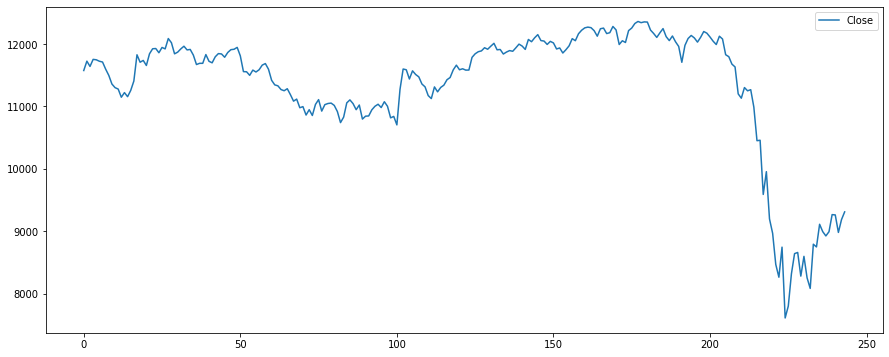

In [7]:
df.plot()

Perform Dickey-Fuller test and Check Stationarity of Series <br>
** Q2. Is the series Stationary? **

In [8]:
#Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


In [9]:
# Stationarity Check - Lets do a quick check on Stationarity with Dickey Fuller Test 
# Convert the DF to series first
ts = df['Close']
test_stationarity(ts)


Results of Dickey-Fuller Test:
Test Statistic                  -1.920447
p-value                          0.322504
#Lags Used                      10.000000
Number of Observations Used    233.000000
Critical Value (1%)             -3.458731
Critical Value (5%)             -2.874026
Critical Value (10%)            -2.573424
dtype: float64


# Make Time Series Stationary

** Q3. After making the Series stationary. Does it passes the Dickey Fuller Test? **

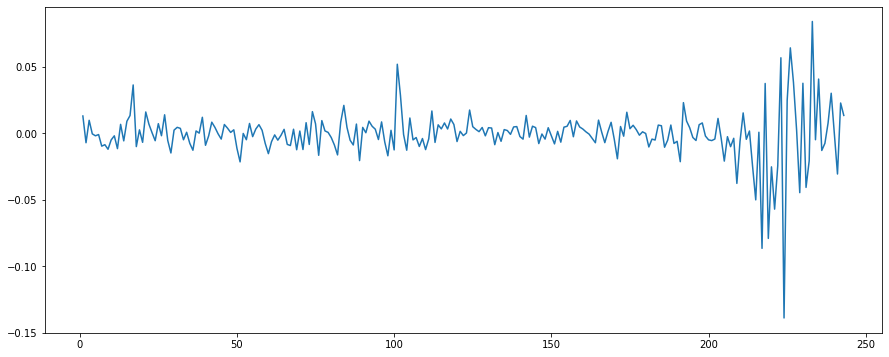

In [10]:
# There is a significant positive trend. We can apply transformation which penalize higher values more than smaller values
# These can be taking a log, cube root, etc. We take  a log transform
ts_log = np.log(ts)
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

In [11]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

Results of Dickey-Fuller Test:
Test Statistic                  -3.187282
p-value                          0.020733
#Lags Used                      15.000000
Number of Observations Used    227.000000
Critical Value (1%)             -3.459490
Critical Value (5%)             -2.874358
Critical Value (10%)            -2.573602
dtype: float64


# Forecast Time Series

Lets Use the ARIMA model <br>
** Q4. What is the RSS error value for ARIMA model after transformation?**

Text(0.5, 1.0, 'RSS: 0.0774')

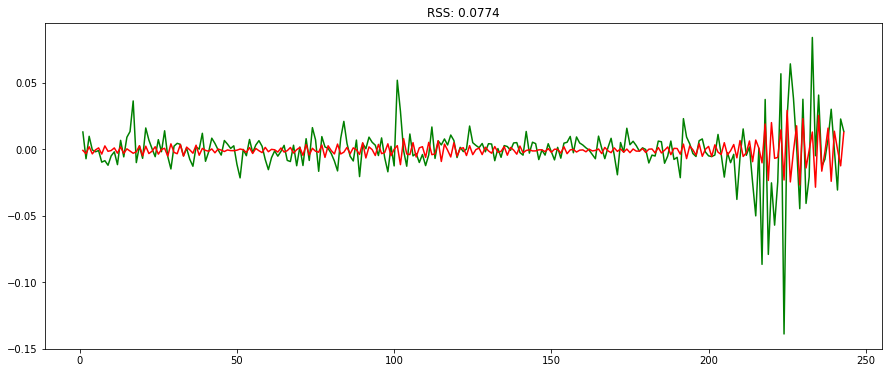

In [12]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff, color='green')
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

### Getting the data back to original scale

In [13]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head(1) )

1   -0.000932
dtype: float64


In [14]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head() )

1   -0.000932
2   -0.004382
3   -0.002600
4   -0.006176
5   -0.006751
dtype: float64


In [15]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

0    9.356685
1    9.355753
2    9.352303
3    9.354085
4    9.350509
dtype: float64

** Q5. What is the RSS error value for ARIMA model at original scale? **

Text(0.5, 1.0, 'RMSE: 1442.9084')

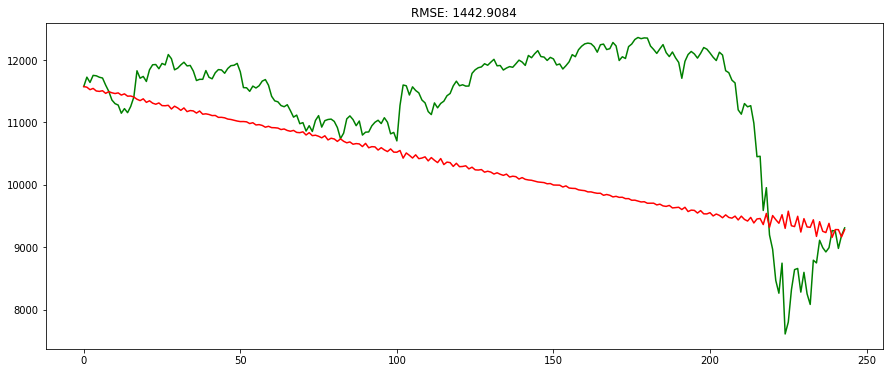

In [16]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts, color='green')
plt.plot(predictions_ARIMA,color='red')
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

This a forecast at the original scale

In [37]:
df.shape
len(predictions_ARIMA_log)
df['predictions']=np.exp(predictions_ARIMA_log)
df.head()

,Date,Close,predictions_ARIMA_log,predictions
0,4/23/2019,11575.95020,9.356685,11575.950200
1,4/24/2019,11726.15039,9.355753,11565.172050
2,4/25/2019,11641.79981,9.352303,11525.335051
3,4/26/2019,11754.65039,9.354085,11545.895602
4,4/30/2019,11748.15039,9.350509,11504.676365


# End

In [20]:
import itertools
p=d=q=range(0,5)
pdq = list(itertools.product(p,d,q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (0, 3, 0),
 (0, 3, 1),
 (0, 3, 2),
 (0, 3, 3),
 (0, 3, 4),
 (0, 4, 0),
 (0, 4, 1),
 (0, 4, 2),
 (0, 4, 3),
 (0, 4, 4),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 0, 4),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (1, 2, 4),
 (1, 3, 0),
 (1, 3, 1),
 (1, 3, 2),
 (1, 3, 3),
 (1, 3, 4),
 (1, 4, 0),
 (1, 4, 1),
 (1, 4, 2),
 (1, 4, 3),
 (1, 4, 4),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 0, 4),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (2, 2, 4),
 (2, 3, 0),
 (2, 3, 1),
 (2, 3, 2),
 (2, 3, 3),
 (2, 3, 4),
 (2, 4, 0),
 (2, 4, 1),
 (2, 4, 2),
 (2, 4, 3),
 (2, 4, 4),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 0, 4),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3,

In [36]:
import warnings
warnings.filterwarnings('ignore')
for param in pdq:
    try:
        model_arima = ARIMA(train,order=param)
        model_arima_fit = model_arima.fit()
        print(param,model_arima_fit.aic)
    except:
        continue
    

[]